In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

## Import Data

In [12]:
fnames = ['/Users/hkromer/02_PhD/02_Data/08.Microwave.PermanentMagnets/Messung01_magneticField.txt', '/Users/hkromer/02_PhD/02_Data/08.Microwave.PermanentMagnets/Messung02_magneticField.txt']

In [13]:
dfs = []
for fname in fnames:
    df = pd.read_csv(fname, skiprows=0, delimiter='\t')
    df.iloc[:,1] = df.iloc[:,1] * 1000 # convert to Gauss
    dfs.append(df)


## Plot

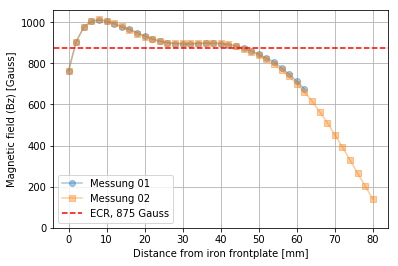

In [14]:
plt.plot(dfs[0].iloc[:,0], dfs[0].iloc[:,1], marker='o',label='Messung 01', alpha=0.4)

plt.plot(dfs[1].iloc[:,0], dfs[1].iloc[:,1], marker='s', label='Messung 02', alpha=0.4)
xlim = plt.gca().get_xlim()
plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')
ylim = plt.gca().get_ylim()
plt.ylim(0, ylim[1])
plt.xlim(xlim)
plt.show()

In [15]:
dfs[1]

,Abstand zur Frontscheibe in mm,Magnetfeld in kG
0,0,761.0
1,2,906.0
2,4,976.0
3,6,1006.0
4,8,1014.0
5,10,1008.0
6,12,996.0
7,14,980.0
8,16,962.0
9,18,945.0


# COMSOL Model
- Iron frontplate is at position 0 mm
- Plasma cup extends into the minus direction
- Data is in /Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1000.1mmHole.csv and /Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.03.relPermIron1000.1mmHole.csv
    - the data is for X {-100, 10, 1}, Y {-5, 5, 0.2}, Z {-5, 5, 0.2}
    - header: X,Y,Z, mfnc.normB (mT)
- From the manufacturer the magnetic flux density in the magnets is typically 1.10T, but certified to be higher than 1.03T
- Original simulation are in /Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/03.undamaged.Br1.10.relPermIron1000.1mmHole_out.mph and /Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/03.undamaged.Br1.03.relPermIron1000.1mmHole_out.mph

## Treat each y and z value separately
- for each x value find the minimum and maximum B field (depending on the y, z values)
- store in a new column
- plot this around the centerline (y=z=0)

## Transform

In the measurement the x=0mm is the frontplate, same is for the COMSOL. But in the COMSOL simulation the x goes in - direction, so everything has to be multiplied with -1.

The values at x =0 is not physical

## Take experimental error into account
- assumption is that ±1.5mm for the position for x<40 mm, and ±3mm for further away

In [16]:
fnames = ['/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.03.relPermIron1000.1mmHole.csv', '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1000.1mmHole.newIron.csv']
output_folder ='/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/'
dfs_comsol = []
dfs_comsol_maxmin = []
dfs_comsol_centerline = []

def find_max_Bfield(df):
    mymax = df['normB_Gauss'].max()
    mymin = df['normB_Gauss'].min()
    return pd.Series({'normB_Gauss_max': mymax, 'normB_Gauss_min': mymin})


# load the files and append into a list of dataframes
for fname in fnames:
    df_comsol = pd.read_csv(fname, skiprows=8)
    df_comsol.columns = ['x', 'y', 'z', 'normB_mT']
    df_comsol['normB_Gauss'] = df_comsol['normB_mT'] * 10
    print(df_comsol.info())
    dfs_comsol.append(df_comsol)
    
    

    df_comsol = df_comsol.sort_values(by=['x'])


    df_comsol_maxmin = df_comsol.groupby('x').apply(lambda x: find_max_Bfield(x))
    # transform
    df_comsol_maxmin['x'] = df_comsol_maxmin.index * -1.0
    df_comsol_maxmin.set_index('x', inplace=True) 
    df_comsol_maxmin.drop([0.0, -1.0], inplace=True)
    dfs_comsol_maxmin.append(df_comsol_maxmin)
    print(df_comsol_maxmin.describe())
    
    df_comsol_centerline = df_comsol[ (df_comsol['y']==0) & (df_comsol['z']==0) ]
    df_comsol_centerline['x'] = df_comsol_centerline['x'] * -1.0
    df_comsol_centerline.set_index('x', inplace=True) 
    dfs_comsol_centerline.append(df_comsol_centerline)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288711 entries, 0 to 288710
Data columns (total 5 columns):
x              288711 non-null float64
y              288711 non-null float64
z              288711 non-null float64
normB_mT       288711 non-null float64
normB_Gauss    288711 non-null float64
dtypes: float64(5)
memory usage: 11.0 MB
None
       normB_Gauss_max  normB_Gauss_min
count       109.000000       109.000000
mean        678.151863       589.432516
std         589.715360       308.598964
min         128.095138         7.404984
25%         378.605960       305.399923
50%         779.556143       751.490501
75%         842.322969       828.443878
max        5986.501683       963.270936


/Users/hkromer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288711 entries, 0 to 288710
Data columns (total 5 columns):
x              288711 non-null float64
y              288711 non-null float64
z              288711 non-null float64
normB_mT       288711 non-null float64
normB_Gauss    288711 non-null float64
dtypes: float64(5)
memory usage: 11.0 MB
None
       normB_Gauss_max  normB_Gauss_min
count       109.000000       109.000000
mean        722.963786       626.578205
std         625.639145       328.946911
min         139.076258         9.900607
25%         402.344926       318.154983
50%         830.901276       799.200468
75%         895.151143       880.241430
max        6333.157727      1097.471284


/Users/hkromer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Experiment and Simulation in comparison

In [17]:
smallerror = 1.5
bigerror = 3
def add_error(row, smallerror, bigerror):
    if row < 40:
        return pd.Series({'x_plus': row+smallerror, 'x_minus': row-smallerror})
    else:
        return pd.Series({'x_plus': row+bigerror, 'x_minus': row-bigerror})

    
a = dfs[1].iloc[:,0].apply(lambda x: add_error(x, smallerror, bigerror))
df_error = pd.concat([a, dfs[1]], axis=1)

In [18]:
# take error into account
from scipy.interpolate import interp1d
f1 = interp1d(df_error['x_plus'], df_error.iloc[:,3], kind='cubic', fill_value="extrapolate")
f2 = interp1d(df_error['x_minus'], df_error.iloc[:,3], kind='cubic', fill_value="extrapolate")

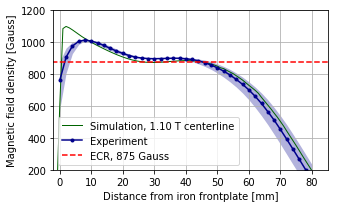

In [19]:
# plt.figure(figsize=(10,7))
fig = plt.figure(figsize=(8*0.60,5*0.60))
# plt.plot(dfs[0].iloc[:,0], dfs[0].iloc[:,1], marker='o',label='Messung 01', alpha=0.75)



plt.plot(dfs_comsol_centerline[1].index, dfs_comsol_centerline[1].loc[:,'normB_Gauss'], color='darkgreen', label='Simulation, 1.10 T centerline',  linewidth=1)
# plt.plot(dfs_comsol_centerline[0].index, dfs_comsol_centerline[0].loc[:,'normB_Gauss'], color='darkgreen', label='Simulation 1.03 T centerline',  linewidth=1)
# plt.plot(dfs_comsol_maxmin[1].index, dfs_comsol_maxmin[1].loc[:,'normB_Gauss_min'], color='darkred', label='Simulation 1.10 T max',  linewidth=1)
# plt.plot(dfs_comsol_maxmin[0].index, dfs_comsol_maxmin[0].loc[:,'normB_Gauss_min'], color='darkorange', label='Simulation 1.03 T min',  linewidth=1)
# plt.fill_between(dfs_comsol_maxmin[0].index, dfs_comsol_maxmin[1].loc[:,'normB_Gauss_min'], dfs_comsol_maxmin[0].loc[:,'normB_Gauss_min'], alpha=0.3,color='darkred')

plt.plot(dfs[1].iloc[:,0], dfs[1].iloc[:,1], marker='o', color='darkblue', markeredgecolor='darkblue', markersize=3, label='Experiment')
plt.fill_between(dfs[1].iloc[:,0], f1(dfs[1].iloc[:,0]), f2(dfs[1].iloc[:,0]), alpha=0.3, color='darkblue', linewidth=0)


xlim = plt.gca().get_xlim()
plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field density [Gauss]')
ylim = plt.gca().get_ylim()
plt.ylim(200, 1200)
plt.xlim(-2,85)
plt.tight_layout()
plt.savefig(f'{output_folder}exp_simu_comparison.pdf', dpi=900)
plt.show()

## Plot

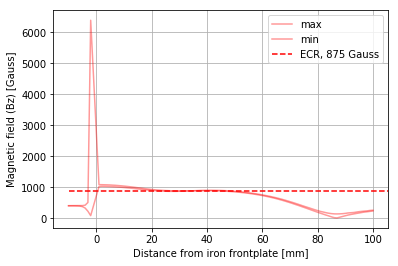

In [119]:
plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_max'], color='red', label='max', alpha=0.4)
plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_min'], color='red', label='min', alpha=0.4)

xlim = plt.gca().get_xlim()
plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')

# plt.ylim(0, ylim[1])
plt.xlim(xlim)
plt.show()

## Experiment and Simulation in comparison

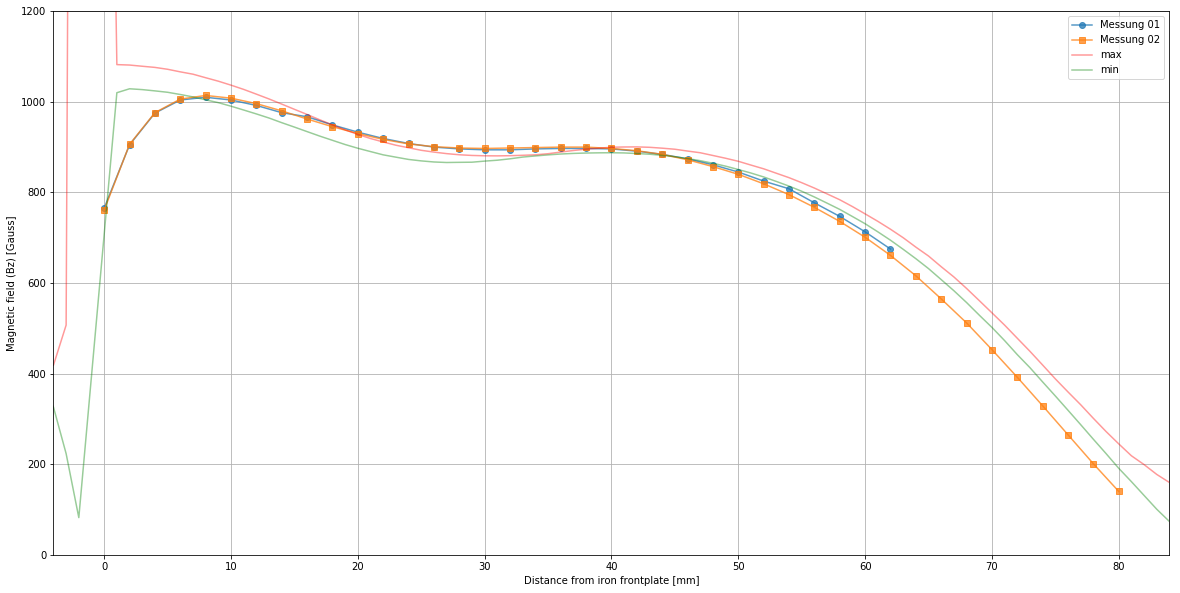

In [120]:
plt.figure(figsize=(20,10))
plt.plot(dfs[0].iloc[:,0], dfs[0].iloc[:,1], marker='o',label='Messung 01', alpha=0.75)

plt.plot(dfs[1].iloc[:,0], dfs[1].iloc[:,1], marker='s', label='Messung 02', alpha=0.75)

xlim = plt.gca().get_xlim()
plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_max'], color='red', label='max', alpha=0.4)
plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_min'], color='green', label='min', alpha=0.4)
# plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')
ylim = plt.gca().get_ylim()
plt.ylim(0, 1200)
plt.xlim(xlim)
plt.show()

## compare different relative iron plate values

In [78]:
path = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/'
fnames = os.listdir(path)
fnames = [f'{path}{f}' for f in fnames if f.endswith('csv')]
fnames

['/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1200.1mmHole.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1600.1mmHole.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron800.1mmHole.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1800.1mmHole.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.03.relPermIron1000.1mmHole.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/BfieldData/02.damaged.Br1.10.relPermIron1000.1mmHole.csv']

In [79]:
dfs = []
def find_max_Bfield(df):
    mymax = df['normB_Gauss'].max()
    mymin = df['normB_Gauss'].min()
    return pd.Series({'normB_Gauss_max': mymax, 'normB_Gauss_min': mymin})

for fname in fnames:
    ID = re.findall(r'Iron(\d+)\.', fname)[0]
    df_comsol = pd.read_csv(fname, skiprows=8)
    df_comsol.columns = ['x', 'y', 'z', 'normB_mT']
    df_comsol['normB_Gauss'] = df_comsol['normB_mT'] * 10
    df_comsol = df_comsol.sort_values(by=['x'])

    df_comsol_maxmin = df_comsol.groupby('x').apply(lambda x: find_max_Bfield(x))
    df_comsol_maxmin['ID'] = ID
    dfs.append(df_comsol_maxmin)

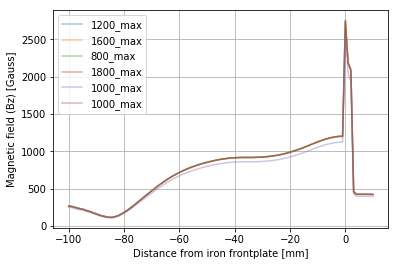

In [80]:
for df_comsol_maxmin in dfs:
    ID = df_comsol_maxmin.ID.unique()[0]
    plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_max'], label=f'{ID}_max', alpha=0.4)

xlim = plt.gca().get_xlim()
# plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')

# plt.ylim(0, ylim[1])
plt.xlim(xlim)
plt.show()

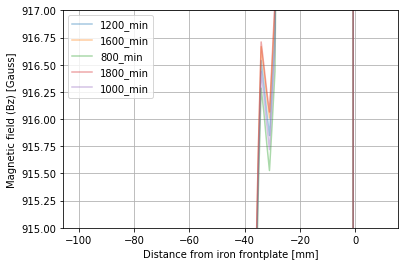

In [58]:
for df_comsol_maxmin in dfs:
    ID = df_comsol_maxmin.ID.unique()[0]
    plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_min'], label=f'{ID}_min', alpha=0.4)

xlim = plt.gca().get_xlim()
# plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')

plt.ylim(915,917)
plt.xlim(xlim)
plt.show()